This notebook is used to test and debug utility functions before integrating them into ```utils.py```.
Functions are migrated from exploratory notebooks (e.g. ```differential_analyse_Borealis.ipynb```) and refined here.

In [2]:
from pathlib import Path
import re
import sys
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter
from scipy import interpolate

In [3]:
# Define standard column aliases
T = 'Test_Time(s)'
I = 'Current(A)'
V = 'Voltage(V)'
V_int = 'Interpolated Voltage (V)'
V_sm = 'Voltage_sm (V)'
Qc = 'Charge_Capacity(Ah)'
Qd = 'Discharge_Capacity(Ah)'
Ec = 'Charge_Energy(Wh)'
Ed = 'Discharge_Energy(Wh)'
dqdv = 'dQ/dV(Ah/V)'
dvdq = 'dV/dQ(V/Ah)'
dqdv_calc = 'dQ/dV (computed from preprocessed V) (Ah/V)'
dvdq_calc = 'dV/dQ (computed from preprocessed V) (V/Ah)'

In [4]:
from pathlib import Path

def get_paths():
    """
    Returns a dictionary of commonly used output paths for plots and data.
    Automatically creates all directories if they do not exist.
    """
    current_dir = Path.cwd()

    paths = {
        "processed_cache": current_dir.parent / 'Data' / 'processed_cache',
        "output_vq_plot_path": current_dir.parent / 'Plots' / 'vq_curves',
        "output_differential_plot_path": current_dir.parent / 'Plots' / 'differential_curves',
        "output_multicycle_plot_path": current_dir.parent / 'Plots' / 'multicycle',
        "output_mono_data_path": current_dir.parent / 'Data' / 'monotonic_segments'
    }

    for path in paths.values():
        path.mkdir(parents=True, exist_ok=True)

    return paths

In [5]:
def build_cycle_file_map():
    """
    Build a mapping from folder number to .xlsx file path. Targeted at the Borealis dataset specifically.

    Returns:
        dict[int, Path]: Mapping of folder number to corresponding Excel file path.
    """
    current_dir = Path.cwd()
    raw_path = current_dir.parent / 'Data' / 'raw_data' / '03-CONSTANT CURRENT protocol_Cycles 0 to 1000'
    cycle_file_map = {}
    for folder_path in sorted(raw_path.glob("Cycle *"), key=lambda p: int(p.name.split()[-1])):
        if folder_path.is_dir():
            folder_no = int(folder_path.name.replace("Cycle ", ""))
            xlsx_files = list(folder_path.glob("*.xlsx"))
            if not xlsx_files:
                print(f"[Warning] No .xlsx file found in {folder_path}")
                continue
            cycle_file_map[folder_no] = xlsx_files[0]
    return cycle_file_map

def read(folder_no, cycle_file_map):
    """
    Read Excel file corresponding to a given folder number.

    Parameters:
        folder_no (int): Folder number
        cycle_file_map (dict): Mapping from folder number to Excel file path

    Returns:
        pd.DataFrame: Loaded Excel file as DataFrame
    """
    if folder_no not in cycle_file_map:
        raise ValueError(f"Folder {folder_no} not found in map.")
    return pd.read_excel(cycle_file_map[folder_no])

In [6]:
def smooth(df, col, window, polyorder, out_col='Voltage_sm (V)'):
    """
    Apply Savitzky-Golay smoothing to a column.

    Parameters:
        df (pd.DataFrame): Input DataFrame
        col (str): Column to smooth
        window (int): Smoothing window size (odd integer)
        polyorder (int): Polynomial order
        out_col (str): Name of the output column

    Returns:
        pd.DataFrame: DataFrame with added smoothed column
    """
    df[out_col] = savgol_filter(df[col], window_length=window, polyorder=polyorder)
    return df

In [7]:
def separate_charge_discharge(cycle_df, cycle_no):
    """
    Separate charge and discharge segments from a cycle DataFrame.

    Parameters:
        cycle_df (pd.DataFrame): Single-cycle DataFrame
        cycle_no (int): Cycle number (for error messages)

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: (charge_df, discharge_df)
    """
    charge_df = cycle_df[cycle_df[I] > 0].copy()
    charge_df = charge_df[[I, T, V, Qc, dvdq, dqdv]].dropna(subset=[I, T, V, Qc]).reset_index(drop=True)
    charge_df = charge_df[charge_df[Qc] > 0].reset_index(drop=True)

    discharge_df = cycle_df[cycle_df[I] < 0].copy()
    discharge_df = discharge_df[[I, T, V, Qd, dvdq, dqdv]].dropna(subset=[I, T, V, Qd]).reset_index(drop=True)
    discharge_df = discharge_df[discharge_df[Qd] > 0].reset_index(drop=True)

    return charge_df, discharge_df

def separate_valid_cycles(df, folder_no, min_seg_length, min_v_variation):
    """
    Identify valid cycles based on length and voltage variation.

    Parameters:
        df (pd.DataFrame): Combined cycle data
        folder_no (int): Folder number
        min_seg_length (int): Minimum rows per segment
        min_v_variation (int): Minimum unique voltages required

    Returns:
        pd.DataFrame: Validated cycle information including segments
    """
    valid_data = []
    for cycle_no, cycle_df in df.groupby("Cycle_Index"):
        charge_df, discharge_df = separate_charge_discharge(cycle_df, cycle_no)
        if (
            charge_df.empty or discharge_df.empty or
            len(charge_df) < min_seg_length or len(discharge_df) < min_seg_length or
            charge_df[V].nunique() < min_v_variation or discharge_df[V].nunique() < min_v_variation
        ):
            continue
        valid_data.append({
            "folder_no": folder_no,
            "cycle_no": cycle_no,
            "charge_df": charge_df,
            "discharge_df": discharge_df
        })
    return pd.DataFrame(valid_data)


In [8]:
# Create the dic for later use: to avoid reloading and enable folder_no -> df
_folder_cache = {}

In [9]:
def select_valid_cycle(folder_nos, cycle_file_map, min_seg_length, min_v_variation):
    """
    Load and process battery data from multiple folders, identify valid cycles,
    and automatically cache the results to disk and memory.

    This function:
    - Reads data from each folder using `read()`.
    - Identifies valid cycles via `separate_valid_cycles()`.
    - Caches both in global `_folder_cache` and local disk (as pickle).
    - Supports restart after interruption (already processed folders are skipped).

    Args:
        folder_nos (list[int]): List of folder indices to process.
        cycle_file_map (dict[int, str]): Mapping from folder number to path.
        min_seg_length (int): Minimum number of points for a valid segment.
        min_v_variation (float): Minimum voltage variation to consider segment valid.

    Returns:
        dict[int, pd.DataFrame]: Mapping from folder number to valid cycles DataFrame.
    """
    result = {}
    
    paths = get_paths()
    save_dir = paths["processed_cache"]

    for folder_no in folder_nos:
        save_path = os.path.join(save_dir, f"folder_{folder_no:04d}.pkl")

        # avoid reloading
        if os.path.exists(save_path):
            print(f"[>>] Skipping folder {folder_no}, already cached.")
            with open(save_path, "rb") as f:
                cache = pickle.load(f)
            _folder_cache[folder_no] = {"df": cache["df"], "folder_no": folder_no}
            result[folder_no] = cache["valid_df"]
            continue

        try:
            if folder_no in _folder_cache:
                df = _folder_cache[folder_no]["df"]
            else:
                df = read(folder_no, cycle_file_map)
                _folder_cache[folder_no] = {"df": df, "folder_no": folder_no}

            valid_df = separate_valid_cycles(df, folder_no, min_seg_length, min_v_variation)

            print(f"[✓] Valid cycles in folder {folder_no}:")
            for c in valid_df['cycle_no'].unique():
                print(f"  - Cycle {c}")
                
                
            with open(save_path, "wb") as f:
                pickle.dump({"df": df, "valid_df": valid_df}, f)

            result[folder_no] = valid_df

        except Exception as e:
            print(f"Error processing folder {folder_no}: {e}")

    return result

In [10]:
def preprocess_segment(df, q_col, no_points, window, polyorder):
    """
    Interpolate and smooth voltage vs. capacity for one segment.

    Parameters:
        df (pd.DataFrame): Raw charge or discharge data
        q_col (str): Capacity column (Qc or Qd)
        no_points (int): Number of interpolation points
        window (int): Smoothing window size
        polyorder (int): Smoothing polynomial order

    Returns:
        pd.DataFrame: Interpolated and smoothed segment
    """
    x = df[q_col]
    x_shifted = x - x.min()
    v, i, t = df[V], df[I], df[T]
    dVdQ, dQdV = df[dvdq], df[dqdv]
    x_shifted, v = map(np.array, (x_shifted, v))
    _, idx = np.unique(x_shifted, return_index=True)
    x_shifted, v = x_shifted[idx], v[idx]
    f_v = interpolate.interp1d(x_shifted, v, kind='cubic', fill_value="extrapolate")
    z = np.linspace(x_shifted.min(), x_shifted.max(), no_points)
    v_interp = f_v(z)
    q_interp = z if q_col == Qc else z[::-1]
    v_interp = v_interp if q_col == Qc else v_interp[::-1]
    min_len = min(len(q_interp), len(v_interp), len(t), len(i), len(dVdQ), len(dQdV))
    result = pd.DataFrame({
        T: t.tolist()[:min_len],
        I: i.tolist()[:min_len],
        q_col: q_interp[:min_len],
        V_int: v_interp[:min_len],
        dvdq: dVdQ.tolist()[:min_len],
        dqdv: dQdV.tolist()[:min_len]
    })
    return smooth(result, V_int, window, polyorder, out_col=V_sm)

def preprocess_single(charge_df, discharge_df, no_points, window, polyorder):
    """
    Preprocess charge and discharge segments of one cycle.

    Parameters:
        charge_df, discharge_df (pd.DataFrame): Raw segments
        no_points, window, polyorder: Smoothing parameters

    Returns:
        Tuple[pd.DataFrame, pd.DataFrame]: (charge, discharge)
    """
    a = preprocess_segment(charge_df, Qc, no_points, window, polyorder)
    b = preprocess_segment(discharge_df, Qd, no_points, window, polyorder)
    return a, b

def process_all(df, folder_no, min_seg_length, min_v_variation,
                no_points, window, polyorder):
    """
    Run preprocessing pipeline on all valid cycles.

    Parameters:
        df (pd.DataFrame): Raw data
        folder_no (int): Folder index
        min_seg_length, min_v_variation: Filter criteria
        no_points, window, polyorder: Smoothing parameters

    Returns:
        list[dict]: Processed charge/discharge data per cycle
    """
    processed = []
    valid_df = separate_valid_cycles(df, folder_no, min_seg_length, min_v_variation)
    for _, row in valid_df.iterrows():
        a, b = preprocess_single(row["charge_df"], row["discharge_df"], no_points, window, polyorder)
        processed.append({
            "folder_no": folder_no,
            "cycle_no": row["cycle_no"],
            "df_charge": a,
            "df_discharge": b
        })
    return processed

In [11]:
# Plotting
def _make_title(kind, folder_no, cycle_no, process):
    return f"{kind} from Folder {folder_no}, Cycle {cycle_no} [{process}]"

def _make_label(kind):
    labels = {
        'q': "Capacity (Ah)",
        'v_sm': "Interpolated + Smoothed Voltage (V)",
        'dqdv': 'dQ/dV (gradient from interpolated + smoothed V)',
        'dvdq': 'dV/dQ (gradient from interpolated + smoothed V)',
        'dvdq_axis': "dV/dQ (V/Ah)",
        'dqdv_axis': "dQ/dV (Ah/V)",
        'vq': 'Interpolated + Smoothed V–Q curve'
    }
    return labels.get(kind, kind)


def plot_preprocessed_qv(df, cycle_no, folder_no,
                         min_seg_length, min_v_variation,
                         no_points, window, polyorder,
                         process, **kwargs):
    """
    Plot smoothed V–Q curve for a given cycle after preprocessing.

    Parameters:
        df (pd.DataFrame): Raw full dataset
        cycle_no (int): Cycle to plot
        folder_no (int): Folder number
        min_seg_length, min_v_variation: Validity criteria
        no_points, window, polyorder: Preprocessing parameters
        process (str): 'charge' or 'discharge'

    Returns:
        pd.DataFrame: The preprocessed DataFrame used for plotting
    """
    processed = process_all(df, folder_no,
                            min_seg_length, min_v_variation,
                            no_points, window, polyorder)

    for entry in processed:
        if entry['cycle_no'] == cycle_no:
            df_pre = entry['df_charge'] if process == 'charge' else entry['df_discharge']
            q = df_pre[Qc] if process == 'charge' else df_pre[Qd]
            v = df_pre[V_sm]
            break
    else:
        print(f"[Warning] Cycle {cycle_no} not found.")
        return None
    
    title = _make_title("Interpolated + Smoothed V–Q", folder_no, cycle_no, process)

    plt.plot(q, v, label=_make_label('vq'), **kwargs)
    plt.xlabel(_make_label('q'))
    plt.ylabel(_make_label('v_sm'))
    plt.grid(True, which='both')
    plt.title(title)
    plt.legend()
    plt.show()

    return df_pre

def plot_pre_derivative(df_pre, folder_no, cycle_no, process, eps, **kwargs):
    """
    Plot dQ/dV and dV/dQ based on the smoothed voltage–capacity curve using numerical gradients.

    Parameters:
        df_pre (pd.DataFrame): Preprocessed charge or discharge segment
        folder_no (int): Folder number (used for naming)
        cycle_no (int): Cycle number (used for naming)
        process (str): 'charge' or 'discharge'
        eps (float): Threshold to filter out unstable gradient points
        **kwargs: Additional keyword arguments for the plot (e.g., linestyle, marker, color)

    Returns:
        Tuple[pd.DataFrame, matplotlib.figure.Figure]:
            - Updated DataFrame with derivative columns
            - Generated matplotlib Figure object
    """
    q_col = Qc if process == 'charge' else Qd
    v = df_pre[V_sm].to_numpy()
    q = df_pre[q_col].to_numpy()

    # Ensure q is sorted in increasing order
    sort_idx = np.argsort(q)
    q, v = q[sort_idx], v[sort_idx]

    # Flip for discharge (so that capacity decreases with voltage)
    if process == 'discharge':
        q = q[::-1]
        v = v[::-1]

    # Compute numerical gradients
    dq, dv = np.gradient(q), np.gradient(v)

    valid_dqdv = np.abs(dv) > eps
    valid_dvdq = np.abs(dq) > eps

    dqdv_vals = np.full_like(q, np.nan)
    dvdq_vals = np.full_like(q, np.nan)
    dqdv_vals[valid_dqdv] = dq[valid_dqdv] / dv[valid_dqdv]
    dvdq_vals[valid_dvdq] = dv[valid_dvdq] / dq[valid_dvdq]

    # Update DataFrame
    df_pre = df_pre.copy()
    df_pre[q_col], df_pre[V_sm] = q, v
    df_pre[dqdv_calc] = dqdv_vals
    df_pre[dvdq_calc] = dvdq_vals

    # Plot
    fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharex=True)
    axes[0].plot(v[valid_dqdv], dqdv_vals[valid_dqdv], label=_make_label('dqdv'), **kwargs)
    axes[1].plot(v[valid_dvdq], dvdq_vals[valid_dvdq], label=_make_label('dvdq'), **kwargs)

    for ax in axes:
        ax.set_xlabel(_make_label("v_sm"))
        ax.grid(True)
        ax.legend()

    axes[0].set_ylabel(_make_label('dqdv_axis'))
    axes[1].set_ylabel(_make_label('dvdq_axis'))
    axes[0].set_title(f'dQ/dV from Folder {folder_no}, Cycle {cycle_no} [{process}]')
    axes[1].set_title(f'dV/dQ from Folder {folder_no}, Cycle {cycle_no} [{process}]')

    plt.tight_layout()
    plt.show()
    
    paths = get_paths()
    mono_path = paths["output_mono_data_path"]

    file_name = f"preprocessed_folder_{folder_no:04d}_cycle_{cycle_no:04d}_{process}.csv"
    df_pre.to_csv(mono_path / file_name, index=False)
    print(f"[✓] Saved preprocessed file with gradients: {file_name}")

    return df_pre, fig


def plot_selected_vq(folder_cycle_pairs, process='charge',
                     min_seg_length=50, min_v_variation=10,
                     no_points=300, window=11, polyorder=3,
                     **kwargs):
    """
    Plot preprocessed V–Q curves for multiple (folder_no, cycle_no) pairs.

    Parameters:
        folder_cycle_pairs (list of tuple): Each element is (folder_no, cycle_no)
    """
    for folder_no, cycle_no in folder_cycle_pairs:
        df = _folder_cache[folder_no]["df"]
        plot_preprocessed_qv(
            df=df,
            cycle_no=cycle_no,
            folder_no=folder_no, 
            min_seg_length=min_seg_length,
            min_v_variation=min_v_variation,
            no_points=no_points,
            window=window,
            polyorder=polyorder,
            process=process,
            **kwargs
        )

In [12]:
def save_from_qrange(
    inputs,  # list of (folder_no, cycle_no, q_min, q_max)
    process,
    min_seg_length,
    min_v_variation,
    no_points,
    window,
    polyorder,
    eps,
    save,
    show,
    dpi,
    **kwargs
):
    """
    Run pipeline for multiple (folder_no, cycle_no, q_min, q_max) configs.
    """
    for folder_no, cycle_no, q_min, q_max in inputs:
        df = _folder_cache[folder_no]["df"]

        # Step 1: Preprocess
        df_pre = plot_preprocessed_qv(
            df, cycle_no, folder_no,
            min_seg_length, min_v_variation,
            no_points, window, polyorder,
            process, **kwargs
        )
        
        paths = get_paths()
        mono_path = paths["output_mono_data_path"]
        vq_plot_path = paths["output_vq_plot_path"]
        differential_plot_path = paths["output_differential_plot_path"]
        
        q_col = Qc if process == 'charge' else Qd
        region = df_pre[(df_pre[q_col] >= q_min) & (df_pre[q_col] <= q_max)].copy()
        file_base = f"preprocessed_folder_{folder_no:04d}_cycle_{cycle_no:04d}_{process}"
        region.to_csv(mono_path / f"{file_base}.csv", index=False)
        print(f"[✓] Saved preprocessed region to {file_base}.csv")

        # Step 2: V–Q Plot
        fig1 = plt.figure()
        plt.plot(region[q_col], region[V_sm], label=_make_label("vq"), **kwargs)
        plt.xlabel(_make_label("q"))
        plt.ylabel(_make_label("v_sm"))
        plt.title(_make_title("vq", folder_no, cycle_no, process))
        plt.grid(True)
        plt.legend()
        if save:
            fig1.savefig(vq_plot_path / f"VQ__F{folder_no}_C{cycle_no}_{process}.png", dpi=dpi, bbox_inches='tight')
        if show:
            plt.show()

        # Step 3: Derivative Plot
        _, fig2 = plot_pre_derivative(region, folder_no, cycle_no, process, eps=eps, **kwargs)
        if save:
            fig2.savefig(differential_plot_path / f"Interp_Sm_Derivatives__F{folder_no}_C{cycle_no}_{process}.png", dpi=dpi, bbox_inches='tight')
        if show:
            plt.show()

## Multicycle plots

In [13]:
def extract_index(file_path):
    match = re.search(r"folder_(\d+)_cycle_(\d+)", file_path.name)
    if match:
        folder_no = int(match.group(1))
        cycle_no = int(match.group(2))
        return f"Cycle {folder_no} – c{cycle_no}"
    
    
def select_process(process):
    paths = get_paths()
    output_path = paths["output_mono_data_path"]
    all_files =  list(output_path.glob(f"preprocessed_*_{process}.csv"))
    
    results = []
    
    for file in all_files:
        df = pd.read_csv(file)
        legend = extract_index(file)
        results.append((df, legend))    
    
    return results

In [14]:
def multi_dvdq_plot(data, **kwargs):
    for df, legend in data:
        plt.plot(df[V_sm], df[dvdq_calc], label=legend, **kwargs)
    plt.xlabel(_make_label("v_sm"))
    plt.ylabel(_make_label("dvdq_axis"))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
def multi_dqdv_plot(data, **kwargs):
    for df, legend in data:
        plt.plot(df[V_sm], df[dqdv_calc], label=legend, **kwargs)
    plt.xlabel(_make_label("v_sm"))
    plt.ylabel(_make_label("dqdv_axis"))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Try to execute

In [15]:
cycle_file_map = build_cycle_file_map()

In [16]:
select_valid_cycle(
    folder_nos=[37, 145, 258, 370, 445, 520, 670, 783, 895, 970],
    cycle_file_map = cycle_file_map, 
    min_seg_length=50,
    min_v_variation=10
)

[✓] Valid cycles in folder 37:
  - Cycle 3
  - Cycle 5
[✓] Valid cycles in folder 145:
  - Cycle 1
  - Cycle 3
  - Cycle 5
  - Cycle 9
[✓] Valid cycles in folder 258:
  - Cycle 5
  - Cycle 9
[✓] Valid cycles in folder 370:
  - Cycle 1
  - Cycle 5
  - Cycle 9
[✓] Valid cycles in folder 445:
  - Cycle 1
  - Cycle 5
  - Cycle 9
[✓] Valid cycles in folder 520:
  - Cycle 1
  - Cycle 5
  - Cycle 9
[✓] Valid cycles in folder 670:
  - Cycle 1
  - Cycle 5
  - Cycle 9
[✓] Valid cycles in folder 783:
  - Cycle 5
  - Cycle 9
[✓] Valid cycles in folder 895:
  - Cycle 1
  - Cycle 5
  - Cycle 9
[✓] Valid cycles in folder 970:
  - Cycle 1
  - Cycle 5
  - Cycle 9


{37:    folder_no  cycle_no                                          charge_df  \
 0         37         3         Current(A)  Test_Time(s)  Voltage(V)  C...   
 1         37         5         Current(A)  Test_Time(s)  Voltage(V)  C...   
 
                                         discharge_df  
 0         Current(A)  Test_Time(s)  Voltage(V)  D...  
 1         Current(A)  Test_Time(s)  Voltage(V)  D...  ,
 145:    folder_no  cycle_no                                          charge_df  \
 0        145         1        Current(A)  Test_Time(s)  Voltage(V)  Ch...   
 1        145         3        Current(A)  Test_Time(s)  Voltage(V)  Ch...   
 2        145         5         Current(A)  Test_Time(s)  Voltage(V)  C...   
 3        145         9         Current(A)  Test_Time(s)  Voltage(V)  C...   
 
                                         discharge_df  
 0        Current(A)  Test_Time(s)  Voltage(V)  Di...  
 1        Current(A)  Test_Time(s)  Voltage(V)  Di...  
 2         Current(A)  Tes

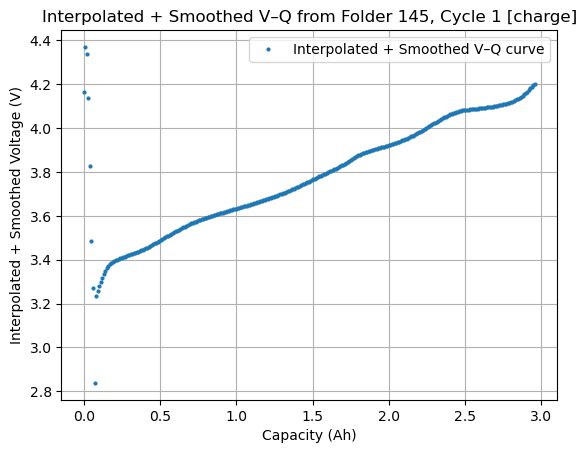

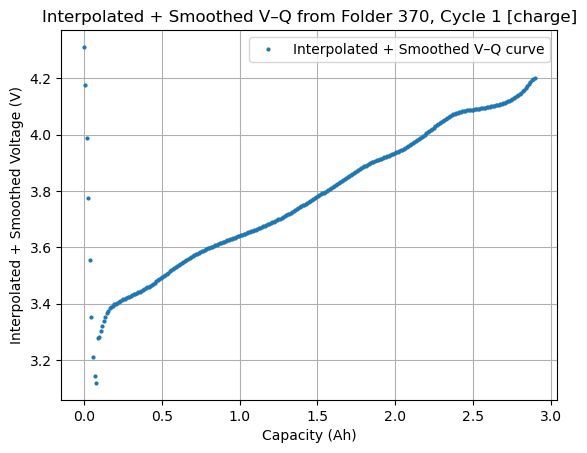

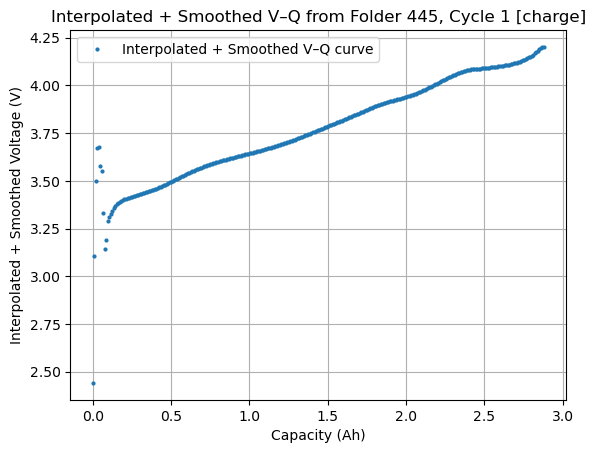

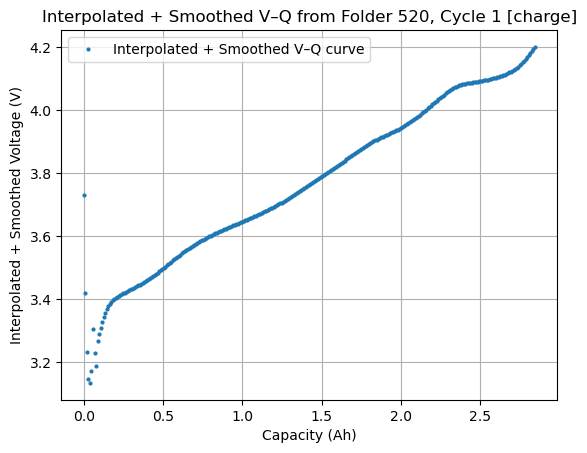

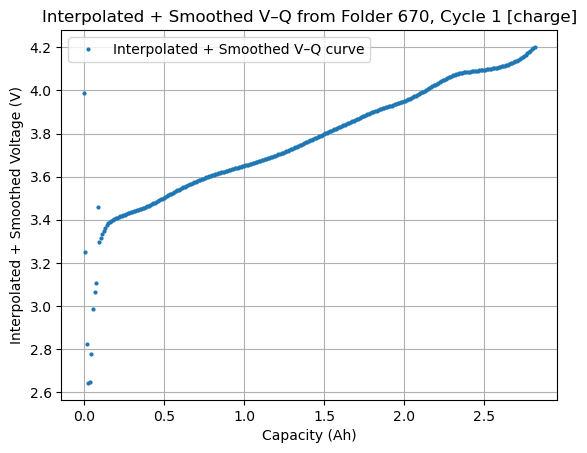

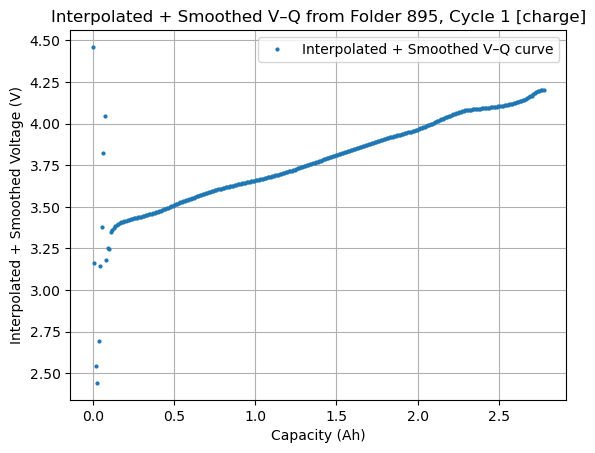

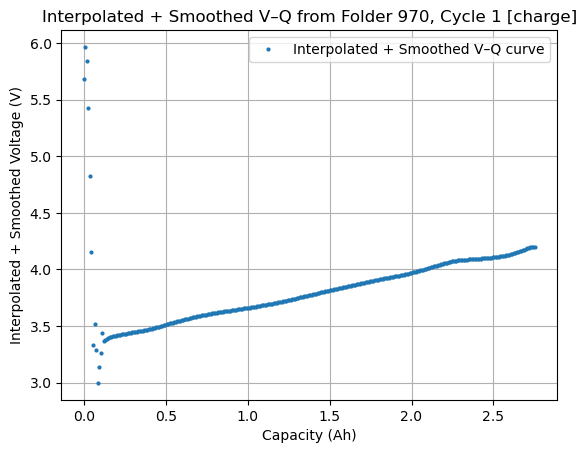

In [26]:
plot_selected_vq(
    folder_cycle_pairs=[(145, 1), (370, 1), (445, 1), (520, 1), (670, 1), (895, 1), (970, 1)],
    process='charge',
    linestyle='none',
    marker='o',
    markersize=2
)

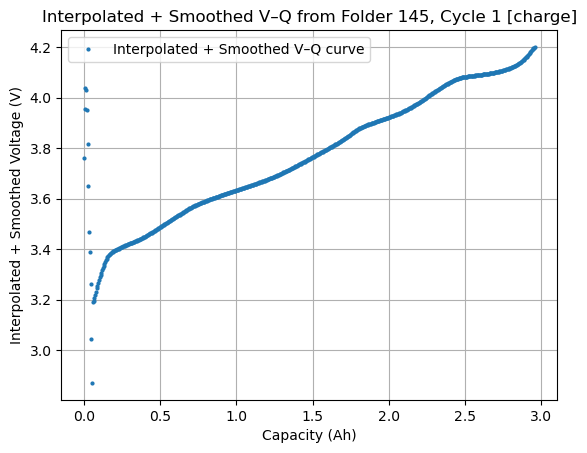

[✓] Saved preprocessed region to preprocessed_folder_0145_cycle_0001_charge.csv


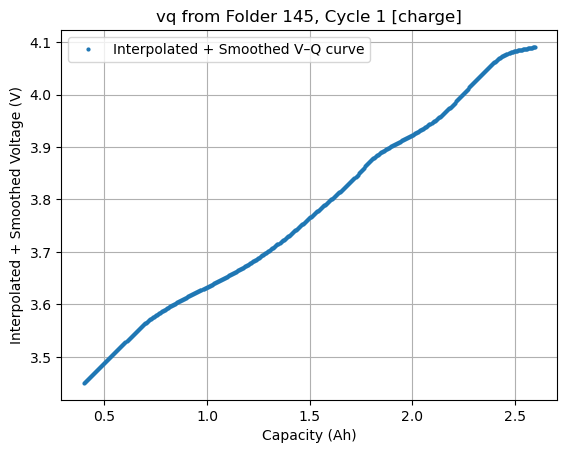

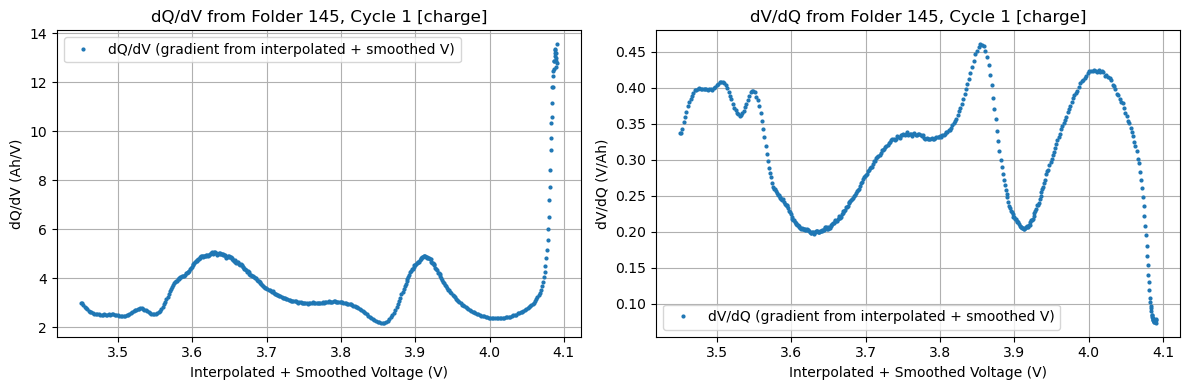

[✓] Saved preprocessed file with gradients: preprocessed_folder_0145_cycle_0001_charge.csv


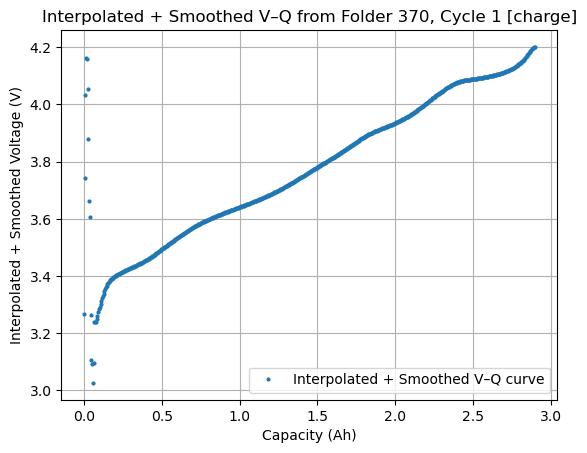

[✓] Saved preprocessed region to preprocessed_folder_0370_cycle_0001_charge.csv


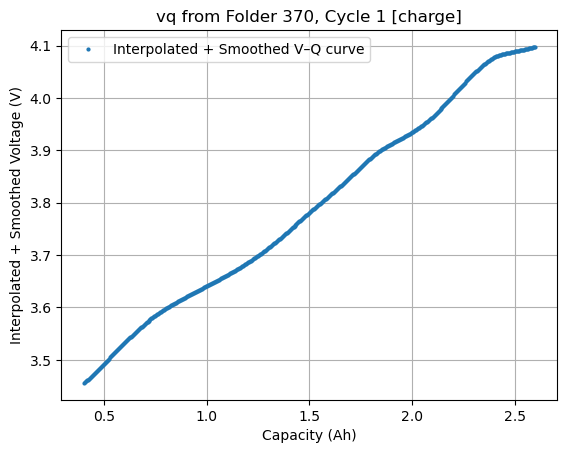

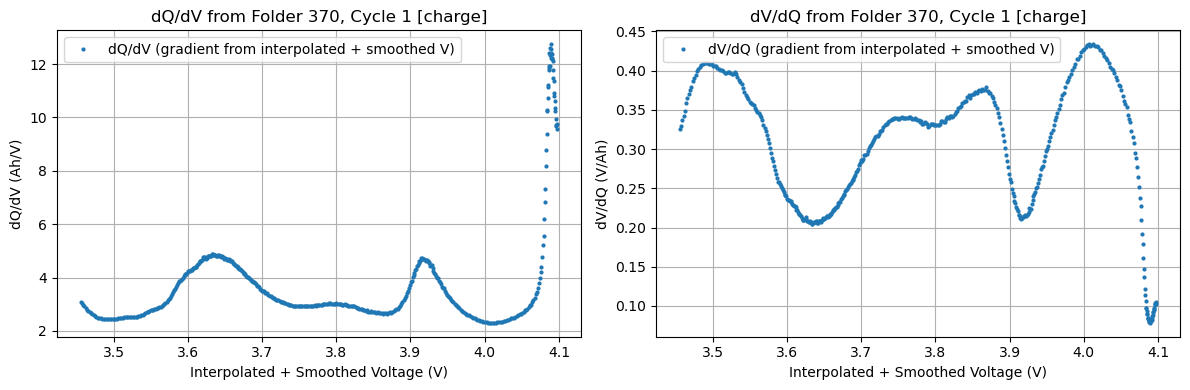

[✓] Saved preprocessed file with gradients: preprocessed_folder_0370_cycle_0001_charge.csv


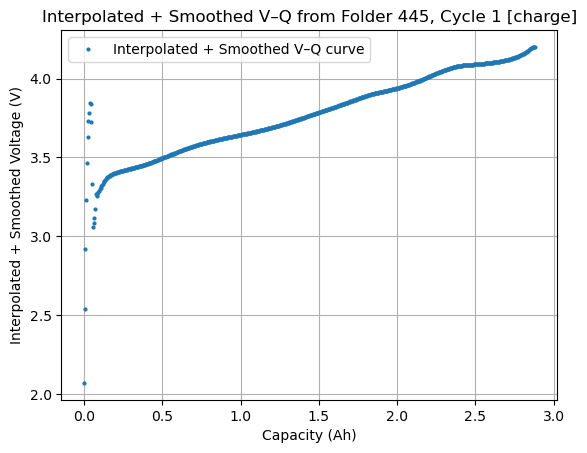

[✓] Saved preprocessed region to preprocessed_folder_0445_cycle_0001_charge.csv


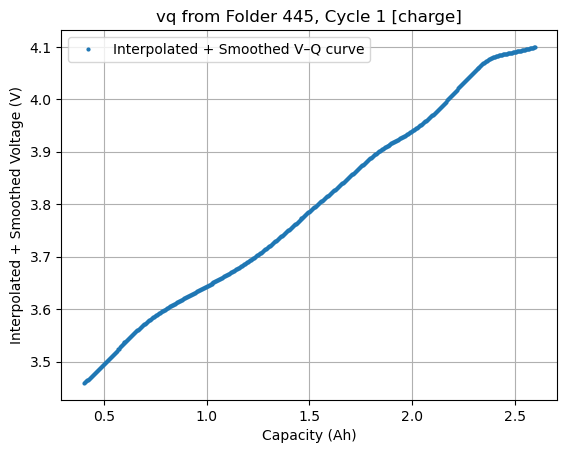

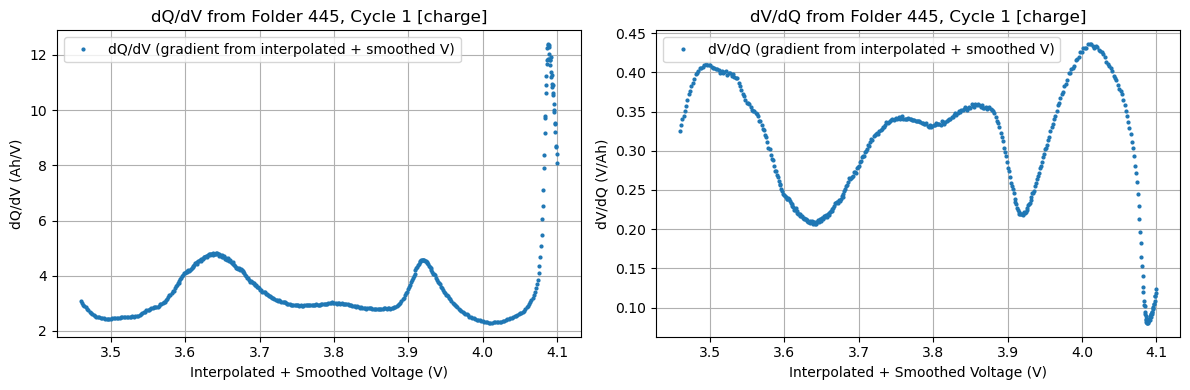

[✓] Saved preprocessed file with gradients: preprocessed_folder_0445_cycle_0001_charge.csv


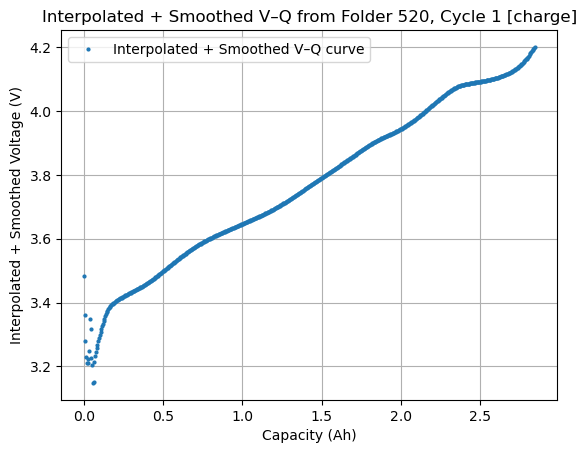

[✓] Saved preprocessed region to preprocessed_folder_0520_cycle_0001_charge.csv


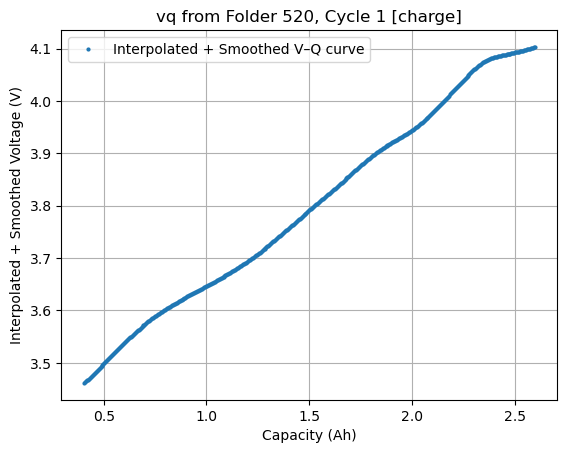

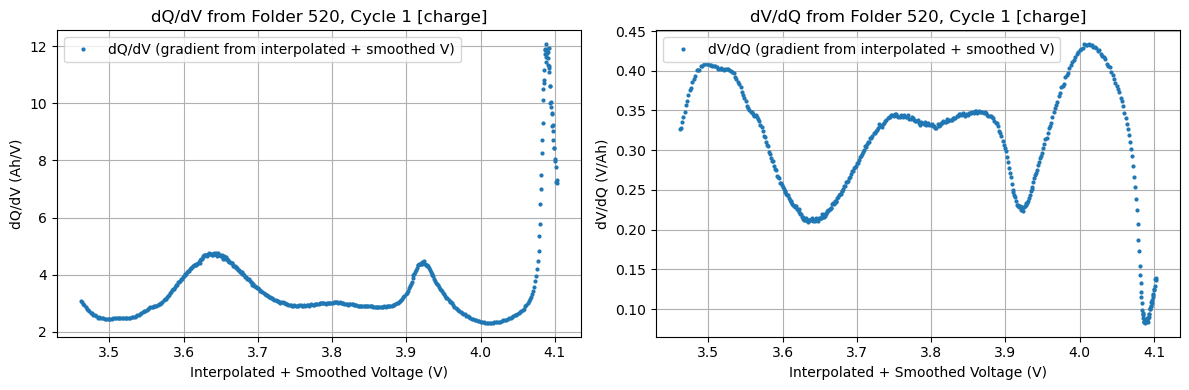

[✓] Saved preprocessed file with gradients: preprocessed_folder_0520_cycle_0001_charge.csv


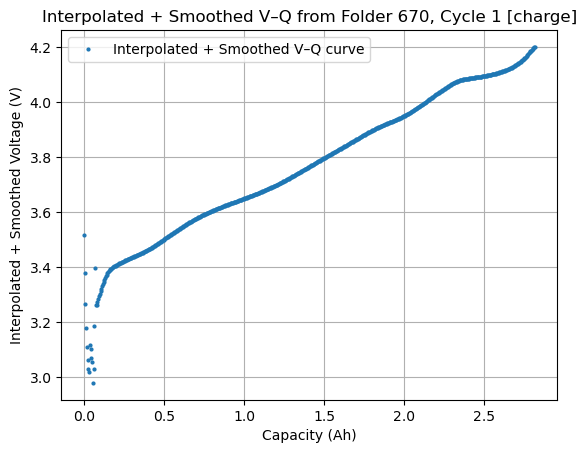

[✓] Saved preprocessed region to preprocessed_folder_0670_cycle_0001_charge.csv


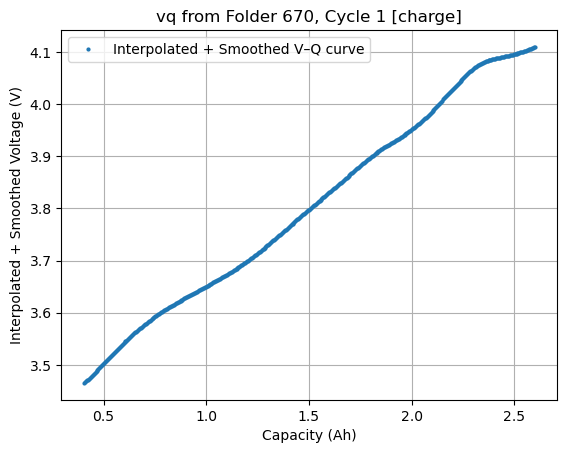

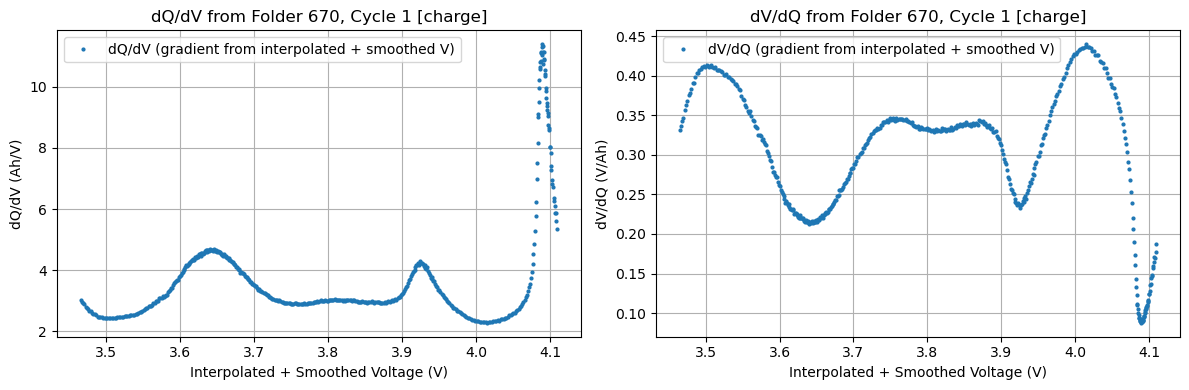

[✓] Saved preprocessed file with gradients: preprocessed_folder_0670_cycle_0001_charge.csv


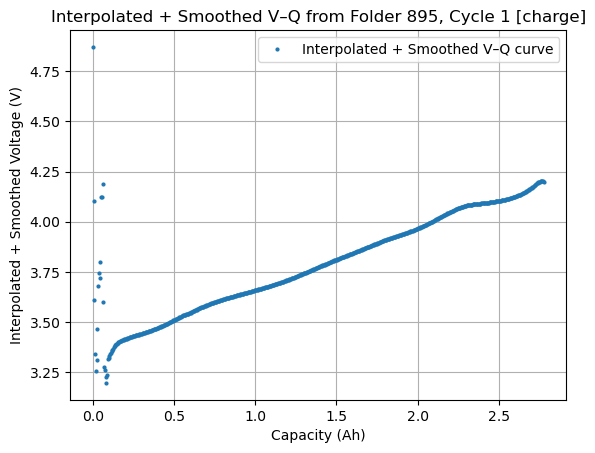

[✓] Saved preprocessed region to preprocessed_folder_0895_cycle_0001_charge.csv


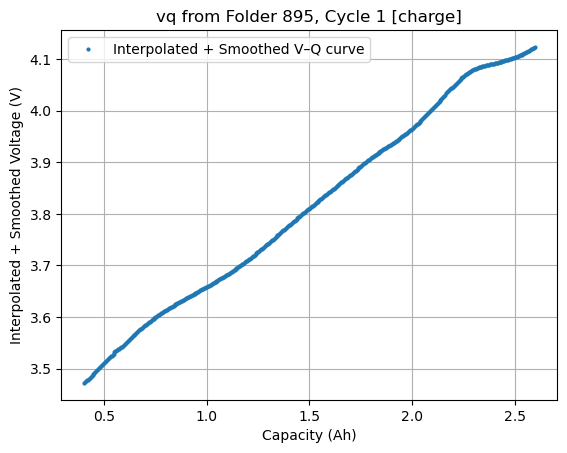

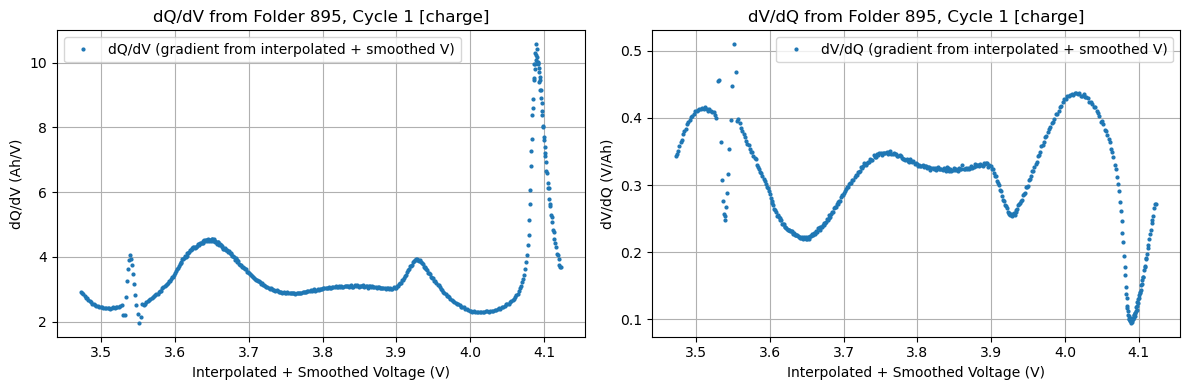

[✓] Saved preprocessed file with gradients: preprocessed_folder_0895_cycle_0001_charge.csv


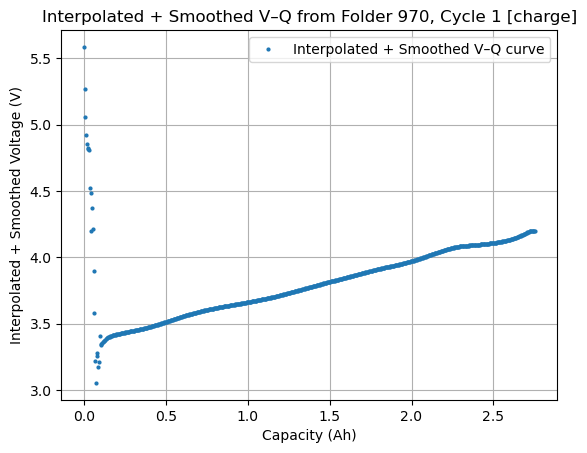

[✓] Saved preprocessed region to preprocessed_folder_0970_cycle_0001_charge.csv


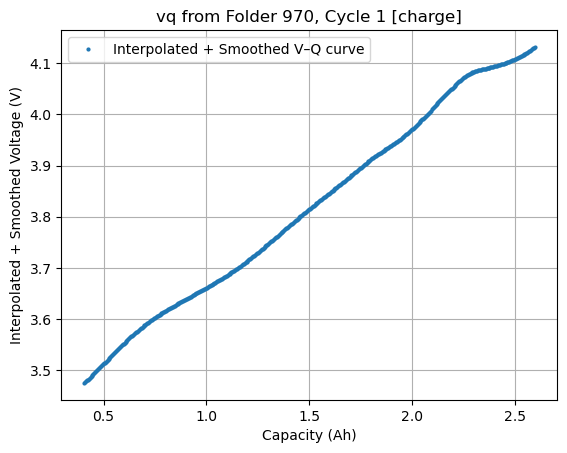

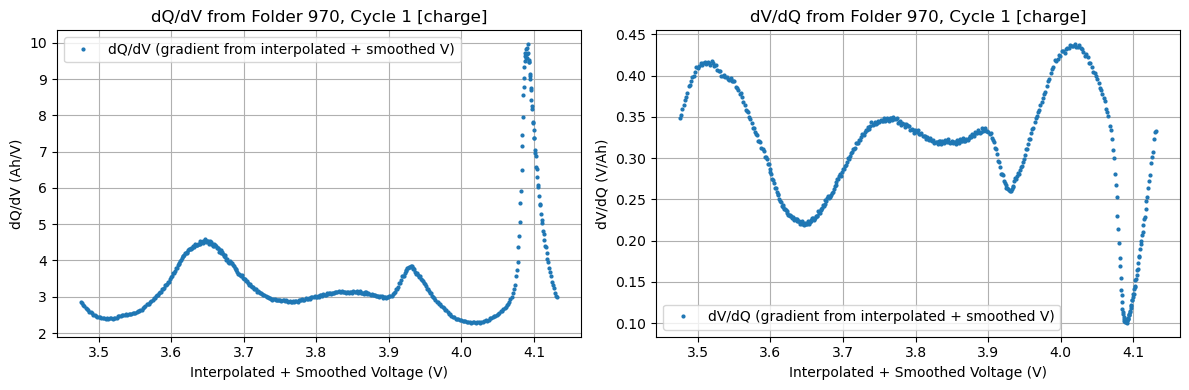

[✓] Saved preprocessed file with gradients: preprocessed_folder_0970_cycle_0001_charge.csv


In [27]:
# Full pipeline: save region and plot all differential curves
save_from_qrange(
    # (folder_no, cycle_no, q_min, q_max)
    inputs = [
        (145, 1, 0.4, 2.6), 
        (370, 1, 0.4, 2.6), 
        (445, 1, 0.4, 2.6), 
        (520, 1, 0.4, 2.6), 
        (670, 1, 0.4, 2.6), 
        (895, 1, 0.4, 2.6), 
        (970, 1, 0.4, 2.6)
    ],
    
    # str, Segment type
    process='charge',
    
    # to filter out valid cycles in each folder
    min_seg_length=50, # int, Minimum number of points in a valid segment
    min_v_variation=10, # int, Minimum number of unique voltage values
    
    # Interpolation
    no_points=600, # int, Points to interpolate for uniform spacing
    
    # Smoothing - Savitzky-Golay filter
    window=15, # int, Window size (must be odd)
    polyorder=3, # int, Polynomial order
    
    # Gradient
    eps=1e-6, # Threshold to avoid division by near-zero
    
    # Saving and displaying
    save=False, show=True, dpi=600,
    
    # **kwargs
    linestyle='none',
    marker='o',
    markersize=2
)

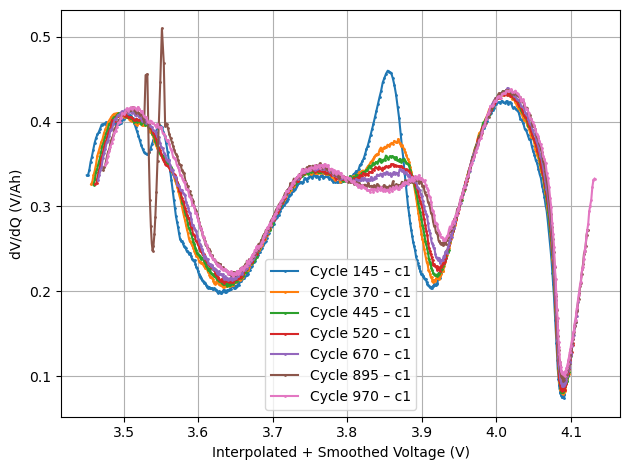

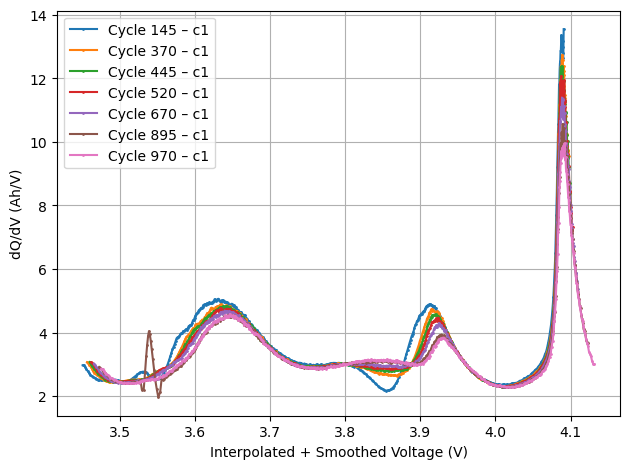

In [31]:
charge_data = select_process('charge')
discharge_data = select_process('discharge')

multi_dvdq_plot(charge_data, linestyle='-', marker='o', markersize=1)
multi_dqdv_plot(charge_data, linestyle='-', marker='o', markersize=1)